In [ ]:
from mesa import Model, Agent
from mesa.datacollection import DataCollector
from mesa.time import SimultaneousActivation
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


class SmallWorldAgentBasic(Agent):

    def __init__(self, unique_id, neighbors,  model):
        '''
         Create a new small world agent.

         Args:
            unique_id: Unique identifier for the agent
            neighbors: list of directly reachable agents
        '''

        super().__init__(unique_id, model)
        self.neighbors = neighbors

        self.infected = False
        self.newly_infected = False
        self.dead = False
        self.candidate_infections = []

    def step(self):
        '''
        Run one step of the agent.
        '''
        self.candidate_infections = []
        if self.dead:
            return

        if self.newly_infected:
            self.infected = True

        if self.infected:
            for neighbor in self.neighbors:
                if self.model.random.random() < self.model.infect_probability:
                    self.candidate_infections.append(neighbor)

    def advance(self):
        '''
        advance step of model
        '''

        if self.dead:
            return

        if self.infected:
            for candidate in self.candidate_infections:
                candidate.newly_infected = True
                print("Agent "+str(candidate.unique_id)+" got infected.\n")
            self.dead = True
            print("Agent "+str(self.unique_id)+" died.\n")


In [13]:
class SmallWorldModel(Model):

    def __init__(self, N, k, p, r):
        '''
        Create a new small world model.

         Args:
            N: how many agents the model contains
            k: how many neighbors an agent has CURRENTLY ONLY EVEN K SUPPORTED
            p: probability of rearranging edge in initialization
            r: probability of infecting another agent
        '''

        super().__init__()

        # 1 Initialization
        self.num_agents = N
        self.num_neighbors = k
        self.swap_probability = p
        self.infect_probability = r
        self.cc = 0
        self.avg_path_length = 0

        self.schedule = SimultaneousActivation(self)
        
        self.datacollector = DataCollector(
            agent_reporters={"Infected": "infected"},
            model_reporters={"Cluster coefficient": "cc", "Average path length": "avg_path_length"}
        )
        
        # Create agents
        for i in range(self.num_agents):
            agent = SmallWorldAgentBasic(i, [0]*k, self)
            self.schedule.add(agent)

        agents = self.schedule.agents
        

        # make the k nearest neighbors the official neighbors
        for j in range(int(self.num_neighbors / 2)):
            for i in range(self.num_agents):
                right = (i + j + 1) % self.num_agents
                left = (i - j - 1) % self.num_agents
                agents[i].neighbors[j*2] = agents[right]
                agents[i].neighbors[j*2+1] = agents[left]

        # randomly replace neighbors with new neighbors
        for j in range(self.num_neighbors):
            for i in range(self.num_agents):
                if self.random.random() < self.swap_probability:
                    candidate_agent = self.random.choice(self.schedule.agents)
                    already_connected = True
                    while already_connected:
                        in_neighbors = False
                        for neighbor in agents[i].neighbors:
                            if neighbor == candidate_agent:
                                in_neighbors = True
                        if in_neighbors:
                            candidate_agent = self.random.choice(self.schedule.agents)
                            already_connected = True
                        else:
                            already_connected = False
                    agents[i].neighbors[j] = candidate_agent
                    print("Agent "+str(i)+"'s new Neighbor on position "+str(j)+" is now Agent "+str(candidate_agent.unique_id)+".\n")

        # clustering coefficient and average path length

        G = nx.Graph()
        cc_sum = 0
        for agent in agents:
            G.add_node(agent.unique_id)

            agent_cc = 0
            neighbor_list = []

            for neighbor in agent.neighbors:
                neighbor_list.append(neighbor.unique_id)
                G.add_edge(agent.unique_id, neighbor.unique_id)
            for neighbor in agent.neighbors:
                for other in neighbor.neighbors:
                    if other.unique_id in neighbor_list:
                        agent_cc = agent_cc + 1

            agent_cc = agent_cc / (self.num_neighbors * (self.num_neighbors - 1))
            cc_sum = cc_sum + agent_cc

        self.cc = cc_sum/self.num_agents
        self.avg_path_length = nx.average_shortest_path_length(G)

        # infect 1 agent
        patient_zero = self.random.choice(self.schedule.agents)
        patient_zero.infected = True
        print("Agent " + str(patient_zero.unique_id) + " got infected.\n")



    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''

        # 3 Step model function
        self.datacollector.collect(self)
        self.schedule.step()

In [14]:
model = SmallWorldModel(100, 4, 0.2, 0.5)
while model.schedule.steps < 100:
    model.step()

Agent 3's new Neighbor on position 0 is now Agent 38.

Agent 8's new Neighbor on position 0 is now Agent 46.

Agent 10's new Neighbor on position 0 is now Agent 13.

Agent 11's new Neighbor on position 0 is now Agent 19.

Agent 14's new Neighbor on position 0 is now Agent 40.

Agent 24's new Neighbor on position 0 is now Agent 61.

Agent 27's new Neighbor on position 0 is now Agent 87.

Agent 31's new Neighbor on position 0 is now Agent 27.

Agent 42's new Neighbor on position 0 is now Agent 45.

Agent 44's new Neighbor on position 0 is now Agent 39.

Agent 55's new Neighbor on position 0 is now Agent 83.

Agent 64's new Neighbor on position 0 is now Agent 26.

Agent 65's new Neighbor on position 0 is now Agent 1.

Agent 68's new Neighbor on position 0 is now Agent 40.

Agent 70's new Neighbor on position 0 is now Agent 84.

Agent 71's new Neighbor on position 0 is now Agent 15.

Agent 74's new Neighbor on position 0 is now Agent 59.

Agent 75's new Neighbor on position 0 is now Agent 

In [15]:
params = {"N": 100, "k": 4, "p": np.linspace(0.1,1.0,10), "r": 0.5}

In [16]:
from mesa.batchrunner import batch_run

results = batch_run(
    SmallWorldModel,
    parameters=params,
    iterations= 5,
    max_steps= 100,
    number_processes=1,
    data_collection_period= -1,
    display_progress=True,
)

4it [00:00, 27.53it/s]

Agent 11's new Neighbor on position 0 is now Agent 16.

Agent 17's new Neighbor on position 0 is now Agent 28.

Agent 28's new Neighbor on position 0 is now Agent 24.

Agent 39's new Neighbor on position 0 is now Agent 4.

Agent 42's new Neighbor on position 0 is now Agent 36.

Agent 55's new Neighbor on position 0 is now Agent 99.

Agent 71's new Neighbor on position 0 is now Agent 68.

Agent 90's new Neighbor on position 0 is now Agent 38.

Agent 23's new Neighbor on position 1 is now Agent 55.

Agent 49's new Neighbor on position 1 is now Agent 67.

Agent 50's new Neighbor on position 1 is now Agent 24.

Agent 69's new Neighbor on position 1 is now Agent 4.

Agent 70's new Neighbor on position 1 is now Agent 66.

Agent 81's new Neighbor on position 1 is now Agent 18.

Agent 86's new Neighbor on position 1 is now Agent 37.

Agent 89's new Neighbor on position 1 is now Agent 1.

Agent 1's new Neighbor on position 2 is now Agent 34.

Agent 8's new Neighbor on position 2 is now Agent 29

7it [00:00, 20.56it/s]


Agent 59 died.

Agent 85 got infected.

Agent 64 died.

Agent 13 got infected.

Agent 79 got infected.

Agent 74 got infected.

Agent 76 died.

Agent 58 got infected.

Agent 79 got infected.

Agent 80 got infected.

Agent 77 died.

Agent 93 died.

Agent 95 got infected.

Agent 90 got infected.

Agent 96 died.

Agent 22 got infected.

Agent 23 died.

Agent 4 got infected.

Agent 63 got infected.

Agent 59 got infected.

Agent 61 died.

Agent 60 got infected.

Agent 75 got infected.

Agent 74 died.

Agent 81 got infected.

Agent 28 got infected.

Agent 78 got infected.

Agent 80 died.

Agent 76 got infected.

Agent 97 got infected.

Agent 65 got infected.

Agent 95 died.

Agent 41 got infected.

Agent 28 died.

Agent 61 got infected.

Agent 40 got infected.

Agent 60 died.

Agent 3 got infected.

Agent 61 got infected.

Agent 63 died.

Agent 74 got infected.

Agent 77 got infected.

Agent 75 died.

Agent 1's new Neighbor on position 0 is now Agent 58.

Agent 2's new Neighbor on position

10it [00:00, 19.91it/s]

Agent 98's new Neighbor on position 1 is now Agent 77.

Agent 99's new Neighbor on position 1 is now Agent 37.

Agent 0's new Neighbor on position 2 is now Agent 27.

Agent 1's new Neighbor on position 2 is now Agent 33.

Agent 2's new Neighbor on position 2 is now Agent 15.

Agent 3's new Neighbor on position 2 is now Agent 99.

Agent 4's new Neighbor on position 2 is now Agent 94.

Agent 5's new Neighbor on position 2 is now Agent 89.

Agent 6's new Neighbor on position 2 is now Agent 13.

Agent 7's new Neighbor on position 2 is now Agent 41.

Agent 8's new Neighbor on position 2 is now Agent 93.

Agent 10's new Neighbor on position 2 is now Agent 90.

Agent 12's new Neighbor on position 2 is now Agent 68.

Agent 13's new Neighbor on position 2 is now Agent 26.

Agent 14's new Neighbor on position 2 is now Agent 10.

Agent 15's new Neighbor on position 2 is now Agent 66.

Agent 17's new Neighbor on position 2 is now Agent 75.

Agent 18's new Neighbor on position 2 is now Agent 26.

A

13it [00:00, 21.68it/s]

Agent 55's new Neighbor on position 2 is now Agent 80.

Agent 57's new Neighbor on position 2 is now Agent 93.

Agent 58's new Neighbor on position 2 is now Agent 71.

Agent 63's new Neighbor on position 2 is now Agent 33.

Agent 65's new Neighbor on position 2 is now Agent 19.

Agent 71's new Neighbor on position 2 is now Agent 67.

Agent 72's new Neighbor on position 2 is now Agent 31.

Agent 75's new Neighbor on position 2 is now Agent 26.

Agent 76's new Neighbor on position 2 is now Agent 45.

Agent 78's new Neighbor on position 2 is now Agent 25.

Agent 82's new Neighbor on position 2 is now Agent 36.

Agent 84's new Neighbor on position 2 is now Agent 77.

Agent 85's new Neighbor on position 2 is now Agent 60.

Agent 87's new Neighbor on position 2 is now Agent 13.

Agent 88's new Neighbor on position 2 is now Agent 82.

Agent 96's new Neighbor on position 2 is now Agent 1.

Agent 5's new Neighbor on position 3 is now Agent 50.

Agent 6's new Neighbor on position 3 is now Agent 

16it [00:00, 19.38it/s]


Agent 93 got infected.

Agent 91 died.

Agent 66 got infected.

Agent 33 got infected.

Agent 14 died.

Agent 47 got infected.

Agent 43 got infected.

Agent 45 died.

Agent 39 got infected.

Agent 58 got infected.

Agent 77 got infected.

Agent 56 died.

Agent 56 got infected.

Agent 13 got infected.

Agent 57 died.

Agent 31 got infected.

Agent 15 got infected.

Agent 73 died.

Agent 47 got infected.

Agent 92 got infected.

Agent 74 died.

Agent 89 got infected.

Agent 85 got infected.

Agent 87 died.

Agent 16 got infected.

Agent 90 got infected.

Agent 88 died.

Agent 94 got infected.

Agent 41 got infected.

Agent 95 got infected.

Agent 0 got infected.

Agent 93 died.

Agent 14 got infected.

Agent 65 got infected.

Agent 79 got infected.

Agent 13 died.

Agent 17 got infected.

Agent 16 died.

Agent 34 got infected.

Agent 90 got infected.

Agent 88 got infected.

Agent 31 got infected.

Agent 33 died.

Agent 40 got infected.

Agent 24 got infected.

Agent 37 got infected.



22it [00:01, 20.40it/s]


Agent 25's new Neighbor on position 2 is now Agent 34.

Agent 26's new Neighbor on position 2 is now Agent 99.

Agent 27's new Neighbor on position 2 is now Agent 93.

Agent 28's new Neighbor on position 2 is now Agent 72.

Agent 29's new Neighbor on position 2 is now Agent 75.

Agent 30's new Neighbor on position 2 is now Agent 92.

Agent 31's new Neighbor on position 2 is now Agent 32.

Agent 32's new Neighbor on position 2 is now Agent 52.

Agent 34's new Neighbor on position 2 is now Agent 61.

Agent 35's new Neighbor on position 2 is now Agent 38.

Agent 36's new Neighbor on position 2 is now Agent 20.

Agent 37's new Neighbor on position 2 is now Agent 37.

Agent 38's new Neighbor on position 2 is now Agent 85.

Agent 39's new Neighbor on position 2 is now Agent 32.

Agent 40's new Neighbor on position 2 is now Agent 23.

Agent 41's new Neighbor on position 2 is now Agent 52.

Agent 42's new Neighbor on position 2 is now Agent 51.

Agent 43's new Neighbor on position 2 is now Ag

25it [00:01, 18.97it/s]

Agent 1 died.

Agent 92 got infected.

Agent 7 got infected.

Agent 63 got infected.

Agent 30 died.

Agent 38 got infected.

Agent 34 got infected.

Agent 36 died.

Agent 62 got infected.

Agent 60 got infected.

Agent 84 got infected.

Agent 61 died.

Agent 80 got infected.

Agent 29 got infected.

Agent 77 got infected.

Agent 79 died.

Agent 2 died.

Agent 6 got infected.

Agent 5 got infected.

Agent 7 died.

Agent 18 got infected.

Agent 21 got infected.

Agent 19 died.

Agent 31 got infected.

Agent 29 died.

Agent 33 got infected.

Agent 40 got infected.

Agent 34 died.

Agent 37 got infected.

Agent 40 got infected.

Agent 38 died.

Agent 60 died.

Agent 78 got infected.

Agent 98 got infected.

Agent 77 died.

Agent 7 got infected.

Agent 82 got infected.

Agent 80 died.

Agent 85 got infected.

Agent 89 got infected.

Agent 84 died.

Agent 93 got infected.

Agent 94 got infected.

Agent 92 died.

Agent 6 got infected.

Agent 7 got infected.

Agent 29 got infected.

Agent 5 d

28it [00:01, 19.43it/s]


Agent 98 got infected.

Agent 10 died.

Agent 67 got infected.

Agent 80 got infected.

Agent 60 died.

Agent 66 got infected.

Agent 65 got infected.

Agent 67 died.

Agent 79 got infected.

Agent 21 got infected.

Agent 80 died.

Agent 68 got infected.

Agent 25 got infected.

Agent 98 died.

Agent 95 got infected.

Agent 29 got infected.

Agent 4 got infected.

Agent 60 got infected.

Agent 21 died.

Agent 27 got infected.

Agent 25 died.

Agent 64 got infected.

Agent 65 died.

Agent 57 got infected.

Agent 39 got infected.

Agent 66 died.

Agent 17 got infected.

Agent 68 died.

Agent 81 got infected.

Agent 77 got infected.

Agent 79 died.

Agent 5 got infected.

Agent 2 got infected.

Agent 4 died.

Agent 72 got infected.

Agent 97 got infected.

Agent 89 got infected.

Agent 17 died.

Agent 28 got infected.

Agent 36 got infected.

Agent 25 got infected.

Agent 27 died.

Agent 30 got infected.

Agent 28 got infected.

Agent 31 got infected.

Agent 29 died.

Agent 6 got infecte

31it [00:01, 18.51it/s]

Agent 60's new Neighbor on position 2 is now Agent 51.

Agent 61's new Neighbor on position 2 is now Agent 78.

Agent 62's new Neighbor on position 2 is now Agent 35.

Agent 63's new Neighbor on position 2 is now Agent 75.

Agent 64's new Neighbor on position 2 is now Agent 15.

Agent 65's new Neighbor on position 2 is now Agent 0.

Agent 66's new Neighbor on position 2 is now Agent 71.

Agent 67's new Neighbor on position 2 is now Agent 74.

Agent 68's new Neighbor on position 2 is now Agent 85.

Agent 69's new Neighbor on position 2 is now Agent 45.

Agent 70's new Neighbor on position 2 is now Agent 92.

Agent 71's new Neighbor on position 2 is now Agent 85.

Agent 72's new Neighbor on position 2 is now Agent 16.

Agent 73's new Neighbor on position 2 is now Agent 40.

Agent 74's new Neighbor on position 2 is now Agent 92.

Agent 75's new Neighbor on position 2 is now Agent 25.

Agent 76's new Neighbor on position 2 is now Agent 85.

Agent 77's new Neighbor on position 2 is now Agen

36it [00:01, 17.25it/s]

Agent 0's new Neighbor on position 0 is now Agent 46.

Agent 1's new Neighbor on position 0 is now Agent 5.

Agent 2's new Neighbor on position 0 is now Agent 55.

Agent 4's new Neighbor on position 0 is now Agent 93.

Agent 11's new Neighbor on position 0 is now Agent 18.

Agent 13's new Neighbor on position 0 is now Agent 97.

Agent 16's new Neighbor on position 0 is now Agent 20.

Agent 17's new Neighbor on position 0 is now Agent 69.

Agent 18's new Neighbor on position 0 is now Agent 34.

Agent 19's new Neighbor on position 0 is now Agent 60.

Agent 20's new Neighbor on position 0 is now Agent 33.

Agent 26's new Neighbor on position 0 is now Agent 65.

Agent 30's new Neighbor on position 0 is now Agent 86.

Agent 31's new Neighbor on position 0 is now Agent 52.

Agent 32's new Neighbor on position 0 is now Agent 67.

Agent 34's new Neighbor on position 0 is now Agent 18.

Agent 37's new Neighbor on position 0 is now Agent 63.

Agent 40's new Neighbor on position 0 is now Agent 5.

38it [00:02, 17.53it/s]


Agent 1's new Neighbor on position 0 is now Agent 43.

Agent 2's new Neighbor on position 0 is now Agent 22.

Agent 3's new Neighbor on position 0 is now Agent 23.

Agent 4's new Neighbor on position 0 is now Agent 87.

Agent 5's new Neighbor on position 0 is now Agent 38.

Agent 6's new Neighbor on position 0 is now Agent 74.

Agent 7's new Neighbor on position 0 is now Agent 63.

Agent 8's new Neighbor on position 0 is now Agent 78.

Agent 9's new Neighbor on position 0 is now Agent 45.

Agent 10's new Neighbor on position 0 is now Agent 69.

Agent 12's new Neighbor on position 0 is now Agent 2.

Agent 14's new Neighbor on position 0 is now Agent 80.

Agent 15's new Neighbor on position 0 is now Agent 71.

Agent 17's new Neighbor on position 0 is now Agent 78.

Agent 18's new Neighbor on position 0 is now Agent 80.

Agent 20's new Neighbor on position 0 is now Agent 13.

Agent 23's new Neighbor on position 0 is now Agent 20.

Agent 24's new Neighbor on position 0 is now Agent 57.

A

43it [00:02, 18.41it/s]


Agent 92 got infected.

Agent 25 got infected.

Agent 29 died.

Agent 20 got infected.

Agent 37 died.

Agent 63 got infected.

Agent 69 got infected.

Agent 63 died.

Agent 94 got infected.

Agent 81 died.

Agent 76 got infected.

Agent 4 died.

Agent 94 got infected.

Agent 21 got infected.

Agent 52 got infected.

Agent 20 died.

Agent 0 got infected.

Agent 15 got infected.

Agent 69 died.

Agent 96 got infected.

Agent 92 died.

Agent 2 got infected.

Agent 82 got infected.

Agent 94 died.

Agent 60 got infected.

Agent 0 died.

Agent 69 got infected.

Agent 91 got infected.

Agent 2 died.

Agent 11 got infected.

Agent 31 got infected.

Agent 74 got infected.

Agent 4 got infected.

Agent 15 died.

Agent 15 got infected.

Agent 52 died.

Agent 66 got infected.

Agent 76 died.

Agent 8 got infected.

Agent 20 got infected.

Agent 82 died.

Agent 27 got infected.

Agent 46 got infected.

Agent 96 died.

Agent 48 got infected.

Agent 49 got infected.

Agent 8 died.

Agent 74 got in

46it [00:02, 19.47it/s]

Agent 50 got infected.

Agent 52 died.

Agent 5 got infected.

Agent 65 got infected.

Agent 67 died.

Agent 70 got infected.

Agent 9 got infected.

Agent 67 got infected.

Agent 69 died.

Agent 88 got infected.

Agent 84 got infected.

Agent 86 died.

Agent 92 got infected.

Agent 44 got infected.

Agent 93 died.

Agent 72 got infected.

Agent 96 got infected.

Agent 66 got infected.

Agent 97 died.

Agent 6 got infected.

Agent 7 got infected.

Agent 5 died.

Agent 5 got infected.

Agent 7 died.

Agent 74 got infected.

Agent 35 got infected.

Agent 11 got infected.

Agent 7 got infected.

Agent 9 died.

Agent 94 got infected.

Agent 28 got infected.

Agent 26 died.

Agent 51 got infected.

Agent 50 died.

Agent 64 got infected.

Agent 67 got infected.

Agent 65 died.

Agent 65 got infected.

Agent 68 got infected.

Agent 66 died.

Agent 77 got infected.

Agent 66 got infected.

Agent 68 died.

Agent 70 died.

Agent 90 got infected.

Agent 72 died.

Agent 86 got infected.

Agent 84 

48it [00:02, 19.18it/s]


Agent 85 died.

Agent 38 got infected.

Agent 10 got infected.

Agent 12 died.

Agent 16 got infected.

Agent 17 got infected.

Agent 15 died.

Agent 87 got infected.

Agent 15 got infected.

Agent 57 got infected.

Agent 16 died.

Agent 58 got infected.

Agent 18 died.

Agent 89 got infected.

Agent 19 died.

Agent 25 got infected.

Agent 45 got infected.

Agent 26 died.

Agent 74 got infected.

Agent 75 got infected.

Agent 27 got infected.

Agent 29 died.

Agent 93 got infected.

Agent 57 got infected.

Agent 46 died.

Agent 84 got infected.

Agent 54 got infected.

Agent 52 died.

Agent 64 died.

Agent 60 got infected.

Agent 28 got infected.

Agent 74 died.

Agent 0 got infected.

Agent 18 got infected.

Agent 51 got infected.

Agent 80 died.

Agent 61 got infected.

Agent 91 got infected.

Agent 94 got infected.

Agent 83 died.

Agent 52 got infected.

Agent 95 died.

Agent 2 got infected.

Agent 54 got infected.

Agent 0 died.

Agent 65 got infected.

Agent 10 died.

Agent 17 g

53it [00:02, 18.52it/s]

Agent 20's new Neighbor on position 0 is now Agent 55.

Agent 51's new Neighbor on position 0 is now Agent 8.

Agent 53's new Neighbor on position 0 is now Agent 40.

Agent 71's new Neighbor on position 0 is now Agent 53.

Agent 78's new Neighbor on position 0 is now Agent 38.

Agent 16's new Neighbor on position 1 is now Agent 66.

Agent 17's new Neighbor on position 1 is now Agent 96.

Agent 24's new Neighbor on position 1 is now Agent 20.

Agent 30's new Neighbor on position 1 is now Agent 58.

Agent 31's new Neighbor on position 1 is now Agent 9.

Agent 37's new Neighbor on position 1 is now Agent 99.

Agent 48's new Neighbor on position 1 is now Agent 96.

Agent 50's new Neighbor on position 1 is now Agent 8.

Agent 51's new Neighbor on position 1 is now Agent 17.

Agent 53's new Neighbor on position 1 is now Agent 65.

Agent 62's new Neighbor on position 1 is now Agent 79.

Agent 64's new Neighbor on position 1 is now Agent 54.

Agent 87's new Neighbor on position 1 is now Agent 

56it [00:02, 20.15it/s]


Agent 68's new Neighbor on position 0 is now Agent 1.

Agent 70's new Neighbor on position 0 is now Agent 80.

Agent 72's new Neighbor on position 0 is now Agent 45.

Agent 74's new Neighbor on position 0 is now Agent 96.

Agent 77's new Neighbor on position 0 is now Agent 24.

Agent 79's new Neighbor on position 0 is now Agent 3.

Agent 80's new Neighbor on position 0 is now Agent 21.

Agent 81's new Neighbor on position 0 is now Agent 25.

Agent 82's new Neighbor on position 0 is now Agent 75.

Agent 87's new Neighbor on position 0 is now Agent 45.

Agent 88's new Neighbor on position 0 is now Agent 71.

Agent 91's new Neighbor on position 0 is now Agent 16.

Agent 92's new Neighbor on position 0 is now Agent 52.

Agent 93's new Neighbor on position 0 is now Agent 74.

Agent 94's new Neighbor on position 0 is now Agent 1.

Agent 95's new Neighbor on position 0 is now Agent 86.

Agent 96's new Neighbor on position 0 is now Agent 89.

Agent 98's new Neighbor on position 0 is now Agent

61it [00:03, 18.70it/s]

Agent 2's new Neighbor on position 0 is now Agent 98.

Agent 3's new Neighbor on position 0 is now Agent 51.

Agent 4's new Neighbor on position 0 is now Agent 16.

Agent 5's new Neighbor on position 0 is now Agent 33.

Agent 6's new Neighbor on position 0 is now Agent 86.

Agent 7's new Neighbor on position 0 is now Agent 22.

Agent 8's new Neighbor on position 0 is now Agent 36.

Agent 9's new Neighbor on position 0 is now Agent 63.

Agent 10's new Neighbor on position 0 is now Agent 13.

Agent 11's new Neighbor on position 0 is now Agent 15.

Agent 12's new Neighbor on position 0 is now Agent 4.

Agent 13's new Neighbor on position 0 is now Agent 16.

Agent 14's new Neighbor on position 0 is now Agent 47.

Agent 15's new Neighbor on position 0 is now Agent 31.

Agent 16's new Neighbor on position 0 is now Agent 63.

Agent 17's new Neighbor on position 0 is now Agent 9.

Agent 18's new Neighbor on position 0 is now Agent 5.

Agent 19's new Neighbor on position 0 is now Agent 31.

Age

63it [00:03, 18.72it/s]

Agent 1 got infected.

Agent 3 died.

Agent 28 got infected.

Agent 29 got infected.

Agent 25 got infected.

Agent 27 died.

Agent 27 got infected.

Agent 26 got infected.

Agent 28 died.

Agent 35 got infected.

Agent 36 got infected.

Agent 34 died.

Agent 33 got infected.

Agent 35 died.

Agent 47 got infected.

Agent 75 got infected.

Agent 45 died.

Agent 50 got infected.

Agent 48 got infected.

Agent 49 died.

Agent 26 got infected.

Agent 58 got infected.

Agent 54 got infected.

Agent 56 died.

Agent 59 died.

Agent 60 got infected.

Agent 59 got infected.

Agent 61 died.

Agent 61 got infected.

Agent 62 died.

Agent 0 got infected.

Agent 1 died.

Agent 26 got infected.

Agent 24 got infected.

Agent 27 got infected.

Agent 25 died.

Agent 27 got infected.

Agent 25 got infected.

Agent 26 died.

Agent 37 got infected.

Agent 35 got infected.

Agent 38 got infected.

Agent 36 died.

Agent 49 got infected.

Agent 48 died.

Agent 49 got infected.

Agent 48 got infected.

Agen

67it [00:03, 21.32it/s]

Agent 25 got infected.

Agent 24 got infected.

Agent 10 got infected.

Agent 40 got infected.

Agent 25 died.

Agent 1 got infected.

Agent 44 got infected.

Agent 70 got infected.

Agent 10 died.

Agent 98 got infected.

Agent 55 got infected.

Agent 83 got infected.

Agent 95 got infected.

Agent 24 died.

Agent 72 got infected.

Agent 40 died.

Agent 29 got infected.

Agent 99 got infected.

Agent 1 died.

Agent 51 got infected.

Agent 44 died.

Agent 56 got infected.

Agent 54 got infected.

Agent 55 died.

Agent 86 got infected.

Agent 70 died.

Agent 72 died.

Agent 44 got infected.

Agent 83 died.

Agent 18 got infected.

Agent 95 died.

Agent 63 got infected.

Agent 21 got infected.

Agent 19 got infected.

Agent 98 died.

Agent 97 got infected.

Agent 16 got infected.

Agent 18 died.

Agent 8 got infected.

Agent 49 got infected.

Agent 21 got infected.

Agent 19 died.

Agent 21 died.

Agent 0 got infected.

Agent 2 got infected.

Agent 29 died.

Agent 9 got infected.

Agent 

70it [00:03, 20.28it/s]


Agent 44's new Neighbor on position 3 is now Agent 4.

Agent 45's new Neighbor on position 3 is now Agent 93.

Agent 46's new Neighbor on position 3 is now Agent 52.

Agent 47's new Neighbor on position 3 is now Agent 8.

Agent 48's new Neighbor on position 3 is now Agent 73.

Agent 49's new Neighbor on position 3 is now Agent 98.

Agent 50's new Neighbor on position 3 is now Agent 0.

Agent 51's new Neighbor on position 3 is now Agent 6.

Agent 52's new Neighbor on position 3 is now Agent 88.

Agent 53's new Neighbor on position 3 is now Agent 44.

Agent 54's new Neighbor on position 3 is now Agent 12.

Agent 55's new Neighbor on position 3 is now Agent 45.

Agent 56's new Neighbor on position 3 is now Agent 21.

Agent 57's new Neighbor on position 3 is now Agent 19.

Agent 58's new Neighbor on position 3 is now Agent 38.

Agent 59's new Neighbor on position 3 is now Agent 78.

Agent 60's new Neighbor on position 3 is now Agent 87.

Agent 61's new Neighbor on position 3 is now Agent 

75it [00:03, 18.49it/s]

Agent 0's new Neighbor on position 0 is now Agent 14.

Agent 1's new Neighbor on position 0 is now Agent 23.

Agent 2's new Neighbor on position 0 is now Agent 21.

Agent 4's new Neighbor on position 0 is now Agent 91.

Agent 11's new Neighbor on position 0 is now Agent 15.

Agent 15's new Neighbor on position 0 is now Agent 43.

Agent 18's new Neighbor on position 0 is now Agent 36.

Agent 20's new Neighbor on position 0 is now Agent 88.

Agent 22's new Neighbor on position 0 is now Agent 94.

Agent 26's new Neighbor on position 0 is now Agent 9.

Agent 32's new Neighbor on position 0 is now Agent 76.

Agent 33's new Neighbor on position 0 is now Agent 81.

Agent 34's new Neighbor on position 0 is now Agent 88.

Agent 38's new Neighbor on position 0 is now Agent 98.

Agent 39's new Neighbor on position 0 is now Agent 12.

Agent 41's new Neighbor on position 0 is now Agent 37.

Agent 45's new Neighbor on position 0 is now Agent 65.

Agent 48's new Neighbor on position 0 is now Agent 94

79it [00:04, 16.66it/s]

Agent 65's new Neighbor on position 1 is now Agent 35.

Agent 66's new Neighbor on position 1 is now Agent 61.

Agent 69's new Neighbor on position 1 is now Agent 85.

Agent 70's new Neighbor on position 1 is now Agent 5.

Agent 72's new Neighbor on position 1 is now Agent 62.

Agent 73's new Neighbor on position 1 is now Agent 32.

Agent 75's new Neighbor on position 1 is now Agent 91.

Agent 78's new Neighbor on position 1 is now Agent 96.

Agent 79's new Neighbor on position 1 is now Agent 64.

Agent 80's new Neighbor on position 1 is now Agent 4.

Agent 81's new Neighbor on position 1 is now Agent 67.

Agent 82's new Neighbor on position 1 is now Agent 33.

Agent 83's new Neighbor on position 1 is now Agent 73.

Agent 84's new Neighbor on position 1 is now Agent 40.

Agent 86's new Neighbor on position 1 is now Agent 63.

Agent 87's new Neighbor on position 1 is now Agent 33.

Agent 88's new Neighbor on position 1 is now Agent 14.

Agent 90's new Neighbor on position 1 is now Agent

81it [00:04, 16.78it/s]

Agent 11's new Neighbor on position 0 is now Agent 65.

Agent 12's new Neighbor on position 0 is now Agent 81.

Agent 13's new Neighbor on position 0 is now Agent 19.

Agent 14's new Neighbor on position 0 is now Agent 7.

Agent 15's new Neighbor on position 0 is now Agent 40.

Agent 16's new Neighbor on position 0 is now Agent 85.

Agent 17's new Neighbor on position 0 is now Agent 60.

Agent 18's new Neighbor on position 0 is now Agent 13.

Agent 19's new Neighbor on position 0 is now Agent 78.

Agent 20's new Neighbor on position 0 is now Agent 20.

Agent 21's new Neighbor on position 0 is now Agent 72.

Agent 22's new Neighbor on position 0 is now Agent 70.

Agent 23's new Neighbor on position 0 is now Agent 80.

Agent 24's new Neighbor on position 0 is now Agent 0.

Agent 25's new Neighbor on position 0 is now Agent 25.

Agent 26's new Neighbor on position 0 is now Agent 21.

Agent 27's new Neighbor on position 0 is now Agent 93.

Agent 28's new Neighbor on position 0 is now Agent

86it [00:04, 18.45it/s]


Agent 1's new Neighbor on position 0 is now Agent 60.

Agent 2's new Neighbor on position 0 is now Agent 96.

Agent 6's new Neighbor on position 0 is now Agent 94.

Agent 10's new Neighbor on position 0 is now Agent 90.

Agent 11's new Neighbor on position 0 is now Agent 36.

Agent 12's new Neighbor on position 0 is now Agent 77.

Agent 13's new Neighbor on position 0 is now Agent 46.

Agent 15's new Neighbor on position 0 is now Agent 15.

Agent 20's new Neighbor on position 0 is now Agent 11.

Agent 23's new Neighbor on position 0 is now Agent 23.

Agent 24's new Neighbor on position 0 is now Agent 75.

Agent 29's new Neighbor on position 0 is now Agent 83.

Agent 30's new Neighbor on position 0 is now Agent 89.

Agent 32's new Neighbor on position 0 is now Agent 9.

Agent 33's new Neighbor on position 0 is now Agent 13.

Agent 36's new Neighbor on position 0 is now Agent 65.

Agent 37's new Neighbor on position 0 is now Agent 8.

Agent 38's new Neighbor on position 0 is now Agent 4

89it [00:04, 17.37it/s]

Agent 3 got infected.

Agent 75 got infected.

Agent 85 got infected.

Agent 3 died.

Agent 37 got infected.

Agent 75 died.

Agent 86 got infected.

Agent 83 got infected.

Agent 85 died.

Agent 78 got infected.

Agent 8 got infected.

Agent 50 got infected.

Agent 37 died.

Agent 82 got infected.

Agent 81 got infected.

Agent 83 died.

Agent 85 got infected.

Agent 71 got infected.

Agent 86 died.

Agent 5 got infected.

Agent 63 got infected.

Agent 8 got infected.

Agent 8 died.

Agent 51 got infected.

Agent 33 got infected.

Agent 93 got infected.

Agent 52 got infected.

Agent 50 died.

Agent 71 died.

Agent 33 got infected.

Agent 76 got infected.

Agent 78 died.

Agent 82 got infected.

Agent 24 got infected.

Agent 81 died.

Agent 81 got infected.

Agent 84 got infected.

Agent 68 got infected.

Agent 82 died.

Agent 6 got infected.

Agent 4 got infected.

Agent 34 got infected.

Agent 5 died.

Agent 24 died.

Agent 2 got infected.

Agent 66 got infected.

Agent 33 died.

Ag

91it [00:04, 17.94it/s]


Agent 24's new Neighbor on position 3 is now Agent 7.

Agent 25's new Neighbor on position 3 is now Agent 47.

Agent 26's new Neighbor on position 3 is now Agent 72.

Agent 27's new Neighbor on position 3 is now Agent 29.

Agent 28's new Neighbor on position 3 is now Agent 44.

Agent 29's new Neighbor on position 3 is now Agent 9.

Agent 30's new Neighbor on position 3 is now Agent 49.

Agent 31's new Neighbor on position 3 is now Agent 59.

Agent 32's new Neighbor on position 3 is now Agent 71.

Agent 33's new Neighbor on position 3 is now Agent 30.

Agent 34's new Neighbor on position 3 is now Agent 40.

Agent 35's new Neighbor on position 3 is now Agent 76.

Agent 36's new Neighbor on position 3 is now Agent 46.

Agent 37's new Neighbor on position 3 is now Agent 33.

Agent 38's new Neighbor on position 3 is now Agent 86.

Agent 39's new Neighbor on position 3 is now Agent 0.

Agent 40's new Neighbor on position 3 is now Agent 78.

Agent 41's new Neighbor on position 3 is now Agent

97it [00:05, 19.42it/s]

Agent 3's new Neighbor on position 0 is now Agent 34.

Agent 4's new Neighbor on position 0 is now Agent 86.

Agent 8's new Neighbor on position 0 is now Agent 74.

Agent 10's new Neighbor on position 0 is now Agent 91.

Agent 12's new Neighbor on position 0 is now Agent 61.

Agent 15's new Neighbor on position 0 is now Agent 9.

Agent 16's new Neighbor on position 0 is now Agent 79.

Agent 17's new Neighbor on position 0 is now Agent 4.

Agent 18's new Neighbor on position 0 is now Agent 4.

Agent 22's new Neighbor on position 0 is now Agent 47.

Agent 23's new Neighbor on position 0 is now Agent 61.

Agent 26's new Neighbor on position 0 is now Agent 37.

Agent 27's new Neighbor on position 0 is now Agent 45.

Agent 28's new Neighbor on position 0 is now Agent 8.

Agent 31's new Neighbor on position 0 is now Agent 63.

Agent 33's new Neighbor on position 0 is now Agent 90.

Agent 36's new Neighbor on position 0 is now Agent 19.

Agent 38's new Neighbor on position 0 is now Agent 97.


99it [00:05, 18.54it/s]

Agent 33 got infected.

Agent 37 died.

Agent 59 got infected.

Agent 46 died.

Agent 45 got infected.

Agent 30 got infected.

Agent 48 got infected.

Agent 56 died.

Agent 73 got infected.

Agent 2 got infected.

Agent 66 died.

Agent 26 got infected.

Agent 74 got infected.

Agent 67 died.

Agent 20 got infected.

Agent 79 got infected.

Agent 81 got infected.

Agent 90 got infected.

Agent 80 died.

Agent 74 got infected.

Agent 93 got infected.

Agent 88 got infected.

Agent 90 died.

Agent 81 got infected.

Agent 52 got infected.

Agent 48 got infected.

Agent 0 died.

Agent 87 got infected.

Agent 68 got infected.

Agent 6 died.

Agent 50 got infected.

Agent 58 got infected.

Agent 20 died.

Agent 28 got infected.

Agent 26 died.

Agent 48 got infected.

Agent 35 got infected.

Agent 33 died.

Agent 78 got infected.

Agent 12 got infected.

Agent 50 got infected.

Agent 35 died.

Agent 44 got infected.

Agent 43 died.

Agent 48 died.

Agent 88 got infected.

Agent 28 got infect

102it [00:05, 19.67it/s]

Agent 27 got infected.

Agent 26 got infected.

Agent 25 got infected.

Agent 27 died.

Agent 26 got infected.

Agent 27 got infected.

Agent 23 got infected.

Agent 25 died.

Agent 27 got infected.

Agent 26 died.

Agent 24 got infected.

Agent 25 got infected.

Agent 21 got infected.

Agent 23 died.

Agent 62 got infected.

Agent 20 got infected.

Agent 23 got infected.

Agent 21 died.

Agent 13 got infected.

Agent 24 died.

Agent 15 got infected.

Agent 13 died.

Agent 22 got infected.

Agent 18 got infected.

Agent 20 died.

Agent 61 got infected.

Agent 60 got infected.

Agent 62 died.

Agent 16 got infected.

Agent 17 got infected.

Agent 15 died.

Agent 19 got infected.

Agent 17 got infected.

Agent 20 got infected.

Agent 77 got infected.

Agent 18 died.

Agent 24 got infected.

Agent 22 died.

Agent 58 got infected.

Agent 60 died.

Agent 62 got infected.

Agent 60 got infected.

Agent 61 died.

Agent 32 got infected.

Agent 15 got infected.

Agent 38 got infected.

Agent 16

107it [00:05, 18.49it/s]

Agent 1's new Neighbor on position 0 is now Agent 87.

Agent 2's new Neighbor on position 0 is now Agent 42.

Agent 3's new Neighbor on position 0 is now Agent 96.

Agent 4's new Neighbor on position 0 is now Agent 76.

Agent 6's new Neighbor on position 0 is now Agent 99.

Agent 8's new Neighbor on position 0 is now Agent 74.

Agent 9's new Neighbor on position 0 is now Agent 66.

Agent 11's new Neighbor on position 0 is now Agent 58.

Agent 15's new Neighbor on position 0 is now Agent 58.

Agent 16's new Neighbor on position 0 is now Agent 82.

Agent 17's new Neighbor on position 0 is now Agent 37.

Agent 18's new Neighbor on position 0 is now Agent 53.

Agent 19's new Neighbor on position 0 is now Agent 51.

Agent 23's new Neighbor on position 0 is now Agent 6.

Agent 24's new Neighbor on position 0 is now Agent 35.

Agent 25's new Neighbor on position 0 is now Agent 64.

Agent 28's new Neighbor on position 0 is now Agent 53.

Agent 30's new Neighbor on position 0 is now Agent 56.



109it [00:05, 16.79it/s]

Agent 71's new Neighbor on position 1 is now Agent 30.

Agent 72's new Neighbor on position 1 is now Agent 47.

Agent 73's new Neighbor on position 1 is now Agent 16.

Agent 74's new Neighbor on position 1 is now Agent 64.

Agent 75's new Neighbor on position 1 is now Agent 60.

Agent 76's new Neighbor on position 1 is now Agent 85.

Agent 77's new Neighbor on position 1 is now Agent 45.

Agent 78's new Neighbor on position 1 is now Agent 27.

Agent 79's new Neighbor on position 1 is now Agent 85.

Agent 80's new Neighbor on position 1 is now Agent 96.

Agent 81's new Neighbor on position 1 is now Agent 49.

Agent 82's new Neighbor on position 1 is now Agent 61.

Agent 83's new Neighbor on position 1 is now Agent 37.

Agent 84's new Neighbor on position 1 is now Agent 66.

Agent 85's new Neighbor on position 1 is now Agent 15.

Agent 86's new Neighbor on position 1 is now Agent 30.

Agent 87's new Neighbor on position 1 is now Agent 93.

Agent 88's new Neighbor on position 1 is now Age

114it [00:06, 16.85it/s]

Agent 74 got infected.

Agent 77 got infected.

Agent 73 got infected.

Agent 75 died.

Agent 13 got infected.

Agent 11 got infected.

Agent 10 got infected.

Agent 12 died.

Agent 34 got infected.

Agent 32 got infected.

Agent 35 got infected.

Agent 33 died.

Agent 74 got infected.

Agent 75 got infected.

Agent 71 got infected.

Agent 73 died.

Agent 75 got infected.

Agent 76 got infected.

Agent 72 got infected.

Agent 74 died.

Agent 12 got infected.

Agent 9 got infected.

Agent 11 died.

Agent 15 got infected.

Agent 13 died.

Agent 35 got infected.

Agent 33 got infected.

Agent 34 died.

Agent 36 got infected.

Agent 34 got infected.

Agent 37 got infected.

Agent 35 died.

Agent 72 died.

Agent 75 got infected.

Agent 76 died.

Agent 16 got infected.

Agent 14 got infected.

Agent 17 got infected.

Agent 53 got infected.

Agent 15 died.

Agent 35 got infected.

Agent 30 got infected.

Agent 34 got infected.

Agent 36 died.

Agent 36 got infected.

Agent 37 died.

Agent 21 

116it [00:06, 17.16it/s]


Agent 2 got infected.

Agent 43 died.

Agent 51 got infected.

Agent 41 got infected.

Agent 50 died.

Agent 35 got infected.

Agent 39 got infected.

Agent 89 died.

Agent 17 got infected.

Agent 94 died.

Agent 0 got infected.

Agent 2 died.

Agent 89 got infected.

Agent 7 got infected.

Agent 9 died.

Agent 19 got infected.

Agent 15 got infected.

Agent 17 died.

Agent 29 got infected.

Agent 37 got infected.

Agent 19 died.

Agent 24 got infected.

Agent 23 died.

Agent 36 got infected.

Agent 35 died.

Agent 40 got infected.

Agent 38 got infected.

Agent 37 got infected.

Agent 39 died.

Agent 39 got infected.

Agent 41 died.

Agent 52 got infected.

Agent 50 got infected.

Agent 51 died.

Agent 99 got infected.

Agent 90 got infected.

Agent 98 got infected.

Agent 0 died.

Agent 8 got infected.

Agent 5 got infected.

Agent 7 died.

Agent 53 got infected.

Agent 13 got infected.

Agent 15 died.

Agent 23 got infected.

Agent 67 got infected.

Agent 24 died.

Agent 28 got inf

120it [00:06, 15.98it/s]

Agent 47 got infected.

Agent 16 got infected.

Agent 48 died.

Agent 63 got infected.

Agent 51 died.

Agent 60 got infected.

Agent 88 got infected.

Agent 59 died.

Agent 13 got infected.

Agent 62 got infected.

Agent 64 died.

Agent 66 died.

Agent 82 got infected.

Agent 71 died.

Agent 79 got infected.

Agent 77 died.

Agent 32 got infected.

Agent 79 died.

Agent 22 got infected.

Agent 96 got infected.

Agent 81 died.

Agent 23 got infected.

Agent 83 died.

Agent 61 got infected.

Agent 84 got infected.

Agent 85 died.

Agent 61 got infected.

Agent 13 died.

Agent 0 got infected.

Agent 46 got infected.

Agent 82 got infected.

Agent 16 died.

Agent 69 got infected.

Agent 55 got infected.

Agent 57 got infected.

Agent 22 died.

Agent 47 got infected.

Agent 22 got infected.

Agent 23 died.

Agent 33 got infected.

Agent 96 got infected.

Agent 32 died.

Agent 51 got infected.

Agent 23 got infected.

Agent 49 died.

Agent 82 got infected.

Agent 33 died.

Agent 72 got infe

123it [00:06, 17.98it/s]

Agent 53's new Neighbor on position 2 is now Agent 67.

Agent 58's new Neighbor on position 2 is now Agent 94.

Agent 64's new Neighbor on position 2 is now Agent 86.

Agent 65's new Neighbor on position 2 is now Agent 69.

Agent 68's new Neighbor on position 2 is now Agent 41.

Agent 77's new Neighbor on position 2 is now Agent 29.

Agent 78's new Neighbor on position 2 is now Agent 36.

Agent 80's new Neighbor on position 2 is now Agent 43.

Agent 83's new Neighbor on position 2 is now Agent 2.

Agent 96's new Neighbor on position 2 is now Agent 57.

Agent 4's new Neighbor on position 3 is now Agent 69.

Agent 6's new Neighbor on position 3 is now Agent 94.

Agent 8's new Neighbor on position 3 is now Agent 42.

Agent 9's new Neighbor on position 3 is now Agent 85.

Agent 11's new Neighbor on position 3 is now Agent 52.

Agent 15's new Neighbor on position 3 is now Agent 19.

Agent 17's new Neighbor on position 3 is now Agent 66.

Agent 19's new Neighbor on position 3 is now Agent 70

126it [00:06, 17.88it/s]

Agent 20 got infected.

Agent 14 died.

Agent 20 got infected.

Agent 10 got infected.

Agent 12 got infected.

Agent 30 died.

Agent 2 got infected.

Agent 35 got infected.

Agent 37 died.

Agent 38 got infected.

Agent 41 got infected.

Agent 39 died.

Agent 53 got infected.

Agent 54 got infected.

Agent 52 died.

Agent 58 got infected.

Agent 18 got infected.

Agent 57 died.

Agent 66 got infected.

Agent 65 died.

Agent 65 got infected.

Agent 66 got infected.

Agent 68 died.

Agent 72 got infected.

Agent 73 got infected.

Agent 90 got infected.

Agent 71 died.

Agent 77 died.

Agent 82 got infected.

Agent 80 died.

Agent 74 got infected.

Agent 21 got infected.

Agent 89 got infected.

Agent 91 died.

Agent 21 got infected.

Agent 99 got infected.

Agent 19 got infected.

Agent 97 died.

Agent 6 got infected.

Agent 53 got infected.

Agent 5 died.

Agent 20 got infected.

Agent 31 got infected.

Agent 18 died.

Agent 20 got infected.

Agent 27 got infected.

Agent 42 got infect

130it [00:07, 16.66it/s]

Agent 81 got infected.

Agent 13 got infected.

Agent 20 got infected.

Agent 81 died.

Agent 37 got infected.

Agent 5 got infected.

Agent 71 got infected.

Agent 80 got infected.

Agent 13 died.

Agent 0 got infected.

Agent 20 died.

Agent 1 got infected.

Agent 11 got infected.

Agent 0 died.

Agent 74 got infected.

Agent 9 got infected.

Agent 5 died.

Agent 38 got infected.

Agent 4 got infected.

Agent 37 died.

Agent 70 got infected.

Agent 8 got infected.

Agent 71 died.

Agent 73 got infected.

Agent 59 got infected.

Agent 44 got infected.

Agent 80 died.

Agent 44 got infected.

Agent 6 got infected.

Agent 16 got infected.

Agent 1 died.

Agent 89 got infected.

Agent 4 died.

Agent 82 got infected.

Agent 90 got infected.

Agent 8 died.

Agent 61 got infected.

Agent 81 got infected.

Agent 9 died.

Agent 26 got infected.

Agent 65 got infected.

Agent 11 died.

Agent 37 got infected.

Agent 38 died.

Agent 45 got infected.

Agent 79 got infected.

Agent 44 died.

Agent

133it [00:07, 18.02it/s]


Agent 18 got infected.

Agent 59 died.

Agent 76 got infected.

Agent 60 got infected.

Agent 59 got infected.

Agent 61 died.

Agent 68 got infected.

Agent 65 got infected.

Agent 67 died.

Agent 69 got infected.

Agent 72 got infected.

Agent 70 died.

Agent 70 got infected.

Agent 73 got infected.

Agent 71 died.

Agent 79 got infected.

Agent 78 got infected.

Agent 80 died.

Agent 82 got infected.

Agent 80 got infected.

Agent 83 got infected.

Agent 81 died.

Agent 95 got infected.

Agent 98 got infected.

Agent 96 died.

Agent 4 got infected.

Agent 1 got infected.

Agent 3 died.

Agent 5 got infected.

Agent 11 got infected.

Agent 9 died.

Agent 12 got infected.

Agent 11 got infected.

Agent 13 died.

Agent 66 got infected.

Agent 64 got infected.

Agent 67 got infected.

Agent 65 died.

Agent 69 got infected.

Agent 66 got infected.

Agent 68 died.

Agent 73 got infected.

Agent 72 died.

Agent 72 got infected.

Agent 73 died.

Agent 78 got infected.

Agent 74 got infecte

138it [00:07, 18.91it/s]

Agent 74 got infected.

Agent 76 died.

Agent 82 got infected.

Agent 46 got infected.

Agent 81 died.

Agent 41 got infected.

Agent 87 died.

Agent 27 got infected.

Agent 96 got infected.

Agent 97 died.

Agent 99 got infected.

Agent 0 got infected.

Agent 98 died.

Agent 99 got infected.

Agent 6 got infected.

Agent 0 died.

Agent 15 got infected.

Agent 13 got infected.

Agent 24 got infected.

Agent 14 died.

Agent 87 got infected.

Agent 35 got infected.

Agent 25 got infected.

Agent 27 died.

Agent 51 got infected.

Agent 31 died.

Agent 47 got infected.

Agent 20 got infected.

Agent 46 died.

Agent 42 got infected.

Agent 57 died.

Agent 80 got infected.

Agent 62 got infected.

Agent 64 died.

Agent 70 got infected.

Agent 69 died.

Agent 97 got infected.

Agent 53 got infected.

Agent 96 died.

Agent 21 got infected.

Agent 84 got infected.

Agent 24 died.

Agent 34 got infected.

Agent 37 got infected.

Agent 35 died.

Agent 52 got infected.

Agent 51 died.

Agent 81 go

140it [00:07, 17.01it/s]


Agent 84's new Neighbor on position 2 is now Agent 8.

Agent 86's new Neighbor on position 2 is now Agent 55.

Agent 87's new Neighbor on position 2 is now Agent 31.

Agent 88's new Neighbor on position 2 is now Agent 55.

Agent 90's new Neighbor on position 2 is now Agent 76.

Agent 91's new Neighbor on position 2 is now Agent 51.

Agent 92's new Neighbor on position 2 is now Agent 86.

Agent 93's new Neighbor on position 2 is now Agent 53.

Agent 94's new Neighbor on position 2 is now Agent 93.

Agent 95's new Neighbor on position 2 is now Agent 70.

Agent 97's new Neighbor on position 2 is now Agent 84.

Agent 98's new Neighbor on position 2 is now Agent 66.

Agent 99's new Neighbor on position 2 is now Agent 69.

Agent 0's new Neighbor on position 3 is now Agent 19.

Agent 1's new Neighbor on position 3 is now Agent 62.

Agent 2's new Neighbor on position 3 is now Agent 28.

Agent 3's new Neighbor on position 3 is now Agent 71.

Agent 4's new Neighbor on position 3 is now Agent 57

143it [00:07, 19.51it/s]


Agent 8 got infected.

Agent 80 got infected.

Agent 7 got infected.

Agent 9 died.

Agent 10 got infected.

Agent 12 died.

Agent 17 got infected.

Agent 15 got infected.

Agent 14 got infected.

Agent 16 died.

Agent 18 got infected.

Agent 72 got infected.

Agent 17 got infected.

Agent 19 died.

Agent 20 died.

Agent 20 got infected.

Agent 61 got infected.

Agent 21 died.

Agent 21 got infected.

Agent 20 got infected.

Agent 22 died.

Agent 27 got infected.

Agent 28 got infected.

Agent 57 got infected.

Agent 26 died.

Agent 27 got infected.

Agent 74 got infected.

Agent 26 got infected.

Agent 28 died.

Agent 35 got infected.

Agent 33 got infected.

Agent 34 died.

Agent 40 got infected.

Agent 38 got infected.

Agent 37 got infected.

Agent 39 died.

Agent 51 got infected.

Agent 52 got infected.

Agent 48 got infected.

Agent 50 died.

Agent 51 got infected.

Agent 54 got infected.

Agent 52 died.

Agent 11 got infected.

Agent 73 got infected.

Agent 72 got infected.

Ag

148it [00:08, 18.62it/s]

Agent 0's new Neighbor on position 0 is now Agent 91.

Agent 1's new Neighbor on position 0 is now Agent 6.

Agent 3's new Neighbor on position 0 is now Agent 64.

Agent 4's new Neighbor on position 0 is now Agent 9.

Agent 5's new Neighbor on position 0 is now Agent 28.

Agent 7's new Neighbor on position 0 is now Agent 65.

Agent 10's new Neighbor on position 0 is now Agent 23.

Agent 11's new Neighbor on position 0 is now Agent 41.

Agent 12's new Neighbor on position 0 is now Agent 0.

Agent 13's new Neighbor on position 0 is now Agent 72.

Agent 15's new Neighbor on position 0 is now Agent 37.

Agent 16's new Neighbor on position 0 is now Agent 83.

Agent 17's new Neighbor on position 0 is now Agent 5.

Agent 19's new Neighbor on position 0 is now Agent 2.

Agent 20's new Neighbor on position 0 is now Agent 77.

Agent 21's new Neighbor on position 0 is now Agent 49.

Agent 24's new Neighbor on position 0 is now Agent 19.

Agent 26's new Neighbor on position 0 is now Agent 22.

Age

150it [00:08, 14.79it/s]

Agent 98's new Neighbor on position 3 is now Agent 57.

Agent 99's new Neighbor on position 3 is now Agent 30.

Agent 36 got infected.

Agent 43 got infected.

Agent 41 got infected.

Agent 36 died.

Agent 77 got infected.

Agent 2 got infected.

Agent 96 got infected.

Agent 80 got infected.

Agent 41 died.

Agent 7 got infected.

Agent 42 got infected.

Agent 0 got infected.

Agent 43 died.

Agent 1 got infected.

Agent 0 died.

Agent 36 got infected.

Agent 67 got infected.

Agent 10 got infected.

Agent 2 died.

Agent 71 got infected.

Agent 7 died.

Agent 89 got infected.

Agent 67 got infected.

Agent 42 died.

Agent 95 got infected.

Agent 77 died.

Agent 93 got infected.

Agent 15 got infected.

Agent 80 died.

Agent 9 got infected.

Agent 62 got infected.

Agent 96 died.

Agent 42 got infected.

Agent 95 got infected.

Agent 59 got infected.

Agent 6 got infected.

Agent 1 died.

Agent 74 got infected.

Agent 9 died.

Agent 86 got infected.

Agent 63 got infected.

Agent 10 di

153it [00:08, 17.47it/s]


Agent 13 got infected.

Agent 9 got infected.

Agent 11 died.

Agent 10 got infected.

Agent 8 got infected.

Agent 11 got infected.

Agent 9 died.

Agent 14 got infected.

Agent 12 got infected.

Agent 15 got infected.

Agent 13 died.

Agent 7 got infected.

Agent 6 got infected.

Agent 8 died.

Agent 11 got infected.

Agent 9 got infected.

Agent 12 got infected.

Agent 10 died.

Agent 14 got infected.

Agent 10 got infected.

Agent 12 died.

Agent 15 got infected.

Agent 16 got infected.

Agent 12 got infected.

Agent 14 died.

Agent 53 got infected.

Agent 17 got infected.

Agent 15 died.

Agent 7 got infected.

Agent 6 died.

Agent 66 got infected.

Agent 7 died.

Agent 17 got infected.

Agent 18 got infected.

Agent 16 died.

Agent 16 got infected.

Agent 15 got infected.

Agent 17 died.

Agent 54 got infected.

Agent 51 got infected.

Agent 53 died.

Agent 19 got infected.

Agent 20 got infected.

Agent 18 died.

Agent 52 got infected.

Agent 50 got infected.

Agent 53 got infe

157it [00:08, 17.52it/s]


Agent 17 got infected.

Agent 13 got infected.

Agent 15 died.

Agent 50 got infected.

Agent 31 got infected.

Agent 24 died.

Agent 59 got infected.

Agent 26 got infected.

Agent 29 died.

Agent 21 got infected.

Agent 97 got infected.

Agent 30 got infected.

Agent 32 died.

Agent 34 died.

Agent 37 got infected.

Agent 0 got infected.

Agent 38 died.

Agent 55 got infected.

Agent 56 died.

Agent 2 got infected.

Agent 83 got infected.

Agent 0 died.

Agent 14 got infected.

Agent 50 got infected.

Agent 54 got infected.

Agent 13 died.

Agent 14 died.

Agent 91 got infected.

Agent 19 got infected.

Agent 15 got infected.

Agent 17 died.

Agent 19 got infected.

Agent 21 died.

Agent 31 got infected.

Agent 65 got infected.

Agent 30 died.

Agent 36 got infected.

Agent 53 got infected.

Agent 92 got infected.

Agent 37 died.

Agent 51 got infected.

Agent 95 got infected.

Agent 50 died.

Agent 57 got infected.

Agent 80 got infected.

Agent 55 died.

Agent 60 got infected.

Ag

159it [00:08, 17.59it/s]

Agent 0 got infected.

Agent 19 died.

Agent 28 got infected.

Agent 27 died.

Agent 30 got infected.

Agent 72 got infected.

Agent 29 died.

Agent 10 got infected.

Agent 33 got infected.

Agent 34 died.

Agent 10 got infected.

Agent 90 got infected.

Agent 15 got infected.

Agent 38 died.

Agent 49 got infected.

Agent 84 got infected.

Agent 48 died.

Agent 28 got infected.

Agent 68 died.

Agent 78 got infected.

Agent 77 died.

Agent 2 got infected.

Agent 15 got infected.

Agent 87 died.

Agent 48 got infected.

Agent 94 died.

Agent 95 got infected.

Agent 36 got infected.

Agent 73 got infected.

Agent 0 died.

Agent 89 got infected.

Agent 82 got infected.

Agent 5 got infected.

Agent 2 died.

Agent 40 got infected.

Agent 46 got infected.

Agent 70 got infected.

Agent 3 died.

Agent 66 got infected.

Agent 8 got infected.

Agent 15 died.

Agent 28 died.

Agent 42 got infected.

Agent 46 got infected.

Agent 30 died.

Agent 46 got infected.

Agent 72 died.

Agent 96 got in

164it [00:08, 18.76it/s]

Agent 0's new Neighbor on position 0 is now Agent 0.

Agent 3's new Neighbor on position 0 is now Agent 68.

Agent 5's new Neighbor on position 0 is now Agent 34.

Agent 8's new Neighbor on position 0 is now Agent 42.

Agent 9's new Neighbor on position 0 is now Agent 96.

Agent 13's new Neighbor on position 0 is now Agent 48.

Agent 15's new Neighbor on position 0 is now Agent 2.

Agent 23's new Neighbor on position 0 is now Agent 57.

Agent 24's new Neighbor on position 0 is now Agent 21.

Agent 26's new Neighbor on position 0 is now Agent 39.

Agent 33's new Neighbor on position 0 is now Agent 71.

Agent 38's new Neighbor on position 0 is now Agent 77.

Agent 40's new Neighbor on position 0 is now Agent 31.

Agent 42's new Neighbor on position 0 is now Agent 5.

Agent 45's new Neighbor on position 0 is now Agent 87.

Agent 47's new Neighbor on position 0 is now Agent 80.

Agent 51's new Neighbor on position 0 is now Agent 51.

Agent 55's new Neighbor on position 0 is now Agent 24.



166it [00:09, 17.78it/s]


Agent 1's new Neighbor on position 0 is now Agent 32.

Agent 3's new Neighbor on position 0 is now Agent 24.

Agent 6's new Neighbor on position 0 is now Agent 22.

Agent 9's new Neighbor on position 0 is now Agent 5.

Agent 11's new Neighbor on position 0 is now Agent 58.

Agent 13's new Neighbor on position 0 is now Agent 51.

Agent 15's new Neighbor on position 0 is now Agent 84.

Agent 16's new Neighbor on position 0 is now Agent 0.

Agent 17's new Neighbor on position 0 is now Agent 82.

Agent 19's new Neighbor on position 0 is now Agent 33.

Agent 20's new Neighbor on position 0 is now Agent 86.

Agent 22's new Neighbor on position 0 is now Agent 79.

Agent 23's new Neighbor on position 0 is now Agent 98.

Agent 24's new Neighbor on position 0 is now Agent 98.

Agent 25's new Neighbor on position 0 is now Agent 75.

Agent 26's new Neighbor on position 0 is now Agent 60.

Agent 28's new Neighbor on position 0 is now Agent 91.

Agent 29's new Neighbor on position 0 is now Agent 57

170it [00:09, 16.12it/s]

Agent 58 got infected.

Agent 21 died.

Agent 49 got infected.

Agent 55 got infected.

Agent 36 died.

Agent 2 got infected.

Agent 75 got infected.

Agent 42 died.

Agent 97 got infected.

Agent 47 got infected.

Agent 51 died.

Agent 36 got infected.

Agent 80 got infected.

Agent 63 died.

Agent 55 got infected.

Agent 53 got infected.

Agent 79 died.

Agent 81 got infected.

Agent 23 got infected.

Agent 82 died.

Agent 4 got infected.

Agent 98 got infected.

Agent 20 got infected.

Agent 73 got infected.

Agent 86 died.

Agent 18 got infected.

Agent 47 got infected.

Agent 35 got infected.

Agent 2 died.

Agent 19 got infected.

Agent 21 got infected.

Agent 20 died.

Agent 24 got infected.

Agent 58 got infected.

Agent 23 died.

Agent 50 got infected.

Agent 33 got infected.

Agent 49 died.

Agent 53 died.

Agent 3 got infected.

Agent 14 got infected.

Agent 58 died.

Agent 73 died.

Agent 7 got infected.

Agent 28 got infected.

Agent 96 got infected.

Agent 52 got infected

173it [00:09, 17.61it/s]

Agent 1's new Neighbor on position 1 is now Agent 70.

Agent 5's new Neighbor on position 1 is now Agent 38.

Agent 24's new Neighbor on position 1 is now Agent 74.

Agent 25's new Neighbor on position 1 is now Agent 40.

Agent 31's new Neighbor on position 1 is now Agent 74.

Agent 60's new Neighbor on position 1 is now Agent 4.

Agent 72's new Neighbor on position 1 is now Agent 76.

Agent 76's new Neighbor on position 1 is now Agent 31.

Agent 82's new Neighbor on position 1 is now Agent 79.

Agent 1's new Neighbor on position 2 is now Agent 75.

Agent 2's new Neighbor on position 2 is now Agent 82.

Agent 7's new Neighbor on position 2 is now Agent 59.

Agent 12's new Neighbor on position 2 is now Agent 57.

Agent 20's new Neighbor on position 2 is now Agent 47.

Agent 22's new Neighbor on position 2 is now Agent 78.

Agent 25's new Neighbor on position 2 is now Agent 47.

Agent 29's new Neighbor on position 2 is now Agent 66.

Agent 32's new Neighbor on position 2 is now Agent 55.

178it [00:09, 19.15it/s]


Agent 14 died.

Agent 32 got infected.

Agent 52 got infected.

Agent 53 died.

Agent 39 got infected.

Agent 47 got infected.

Agent 54 died.

Agent 58 got infected.

Agent 59 got infected.

Agent 57 died.

Agent 59 got infected.

Agent 77 got infected.

Agent 97 got infected.

Agent 99 died.

Agent 12 got infected.

Agent 13 died.

Agent 17 got infected.

Agent 67 got infected.

Agent 16 died.

Agent 63 got infected.

Agent 31 got infected.

Agent 30 got infected.

Agent 32 died.

Agent 39 died.

Agent 38 got infected.

Agent 63 got infected.

Agent 49 got infected.

Agent 47 died.

Agent 19 got infected.

Agent 59 died.

Agent 78 got infected.

Agent 67 got infected.

Agent 77 died.

Agent 98 got infected.

Agent 16 got infected.

Agent 81 got infected.

Agent 17 died.

Agent 50 got infected.

Agent 93 got infected.

Agent 49 died.

Agent 94 got infected.

Agent 76 got infected.

Agent 78 died.

Agent 75 got infected.

Agent 76 died.

Agent 34 got infected.

Agent 8 got infected.



180it [00:09, 17.00it/s]


Agent 49 got infected.

Agent 5 got infected.

Agent 70 got infected.

Agent 29 died.

Agent 59 got infected.

Agent 95 got infected.

Agent 56 got infected.

Agent 38 died.

Agent 98 got infected.

Agent 23 got infected.

Agent 46 died.

Agent 37 got infected.

Agent 47 got infected.

Agent 42 got infected.

Agent 3 got infected.

Agent 56 died.

Agent 7 got infected.

Agent 59 died.

Agent 48 got infected.

Agent 91 got infected.

Agent 71 died.

Agent 27 got infected.

Agent 3 died.

Agent 22 got infected.

Agent 41 got infected.

Agent 5 died.

Agent 6 got infected.

Agent 9 got infected.

Agent 5 got infected.

Agent 7 died.

Agent 7 got infected.

Agent 15 got infected.

Agent 37 died.

Agent 8 got infected.

Agent 42 died.

Agent 69 got infected.

Agent 0 got infected.

Agent 44 died.

Agent 42 got infected.

Agent 45 got infected.

Agent 47 died.

Agent 50 got infected.

Agent 48 died.

Agent 54 got infected.

Agent 49 died.

Agent 15 got infected.

Agent 41 got infected.

Age

184it [00:10, 20.12it/s]


Agent 33 got infected.

Agent 31 got infected.

Agent 34 got infected.

Agent 49 got infected.

Agent 32 died.

Agent 63 got infected.

Agent 61 died.

Agent 1's new Neighbor on position 0 is now Agent 21.

Agent 2's new Neighbor on position 0 is now Agent 86.

Agent 3's new Neighbor on position 0 is now Agent 75.

Agent 8's new Neighbor on position 0 is now Agent 4.

Agent 9's new Neighbor on position 0 is now Agent 9.

Agent 10's new Neighbor on position 0 is now Agent 2.

Agent 13's new Neighbor on position 0 is now Agent 48.

Agent 20's new Neighbor on position 0 is now Agent 11.

Agent 24's new Neighbor on position 0 is now Agent 18.

Agent 27's new Neighbor on position 0 is now Agent 57.

Agent 29's new Neighbor on position 0 is now Agent 17.

Agent 30's new Neighbor on position 0 is now Agent 16.

Agent 32's new Neighbor on position 0 is now Agent 95.

Agent 33's new Neighbor on position 0 is now Agent 78.

Agent 46's new Neighbor on position 0 is now Agent 42.

Agent 48's new 

189it [00:10, 18.66it/s]


Agent 35 got infected.

Agent 65 got infected.

Agent 61 got infected.

Agent 63 died.

Agent 74 got infected.

Agent 72 died.

Agent 66 got infected.

Agent 48 got infected.

Agent 65 died.

Agent 88 got infected.

Agent 73 got infected.

Agent 76 got infected.

Agent 94 got infected.

Agent 74 died.

Agent 76 got infected.

Agent 77 died.

Agent 47 got infected.

Agent 48 died.

Agent 94 died.

Agent 40 got infected.

Agent 76 got infected.

Agent 47 died.

Agent 0's new Neighbor on position 0 is now Agent 24.

Agent 1's new Neighbor on position 0 is now Agent 35.

Agent 2's new Neighbor on position 0 is now Agent 54.

Agent 3's new Neighbor on position 0 is now Agent 31.

Agent 6's new Neighbor on position 0 is now Agent 42.

Agent 7's new Neighbor on position 0 is now Agent 37.

Agent 8's new Neighbor on position 0 is now Agent 35.

Agent 9's new Neighbor on position 0 is now Agent 9.

Agent 11's new Neighbor on position 0 is now Agent 27.

Agent 13's new Neighbor on position 0 is

194it [00:10, 17.06it/s]

Agent 5's new Neighbor on position 0 is now Agent 46.

Agent 6's new Neighbor on position 0 is now Agent 27.

Agent 8's new Neighbor on position 0 is now Agent 95.

Agent 9's new Neighbor on position 0 is now Agent 92.

Agent 17's new Neighbor on position 0 is now Agent 70.

Agent 18's new Neighbor on position 0 is now Agent 22.

Agent 21's new Neighbor on position 0 is now Agent 44.

Agent 30's new Neighbor on position 0 is now Agent 21.

Agent 31's new Neighbor on position 0 is now Agent 91.

Agent 36's new Neighbor on position 0 is now Agent 24.

Agent 42's new Neighbor on position 0 is now Agent 88.

Agent 44's new Neighbor on position 0 is now Agent 78.

Agent 55's new Neighbor on position 0 is now Agent 98.

Agent 56's new Neighbor on position 0 is now Agent 60.

Agent 58's new Neighbor on position 0 is now Agent 68.

Agent 63's new Neighbor on position 0 is now Agent 57.

Agent 65's new Neighbor on position 0 is now Agent 38.

Agent 66's new Neighbor on position 0 is now Agent 2

199it [00:10, 19.58it/s]

Agent 82 died.

Agent 87 got infected.

Agent 96 got infected.

Agent 66 got infected.

Agent 99 got infected.

Agent 86 died.

Agent 90 got infected.

Agent 93 got infected.

Agent 91 died.

Agent 10 died.

Agent 53 got infected.

Agent 22 died.

Agent 98 got infected.

Agent 31 died.

Agent 55 got infected.

Agent 9 got infected.

Agent 40 died.

Agent 43 got infected.

Agent 67 got infected.

Agent 42 died.

Agent 67 got infected.

Agent 68 got infected.

Agent 40 got infected.

Agent 66 died.

Agent 11 got infected.

Agent 84 died.

Agent 91 got infected.

Agent 89 got infected.

Agent 92 got infected.

Agent 29 got infected.

Agent 90 died.

Agent 92 got infected.

Agent 95 got infected.

Agent 36 got infected.

Agent 93 died.

Agent 97 got infected.

Agent 45 got infected.

Agent 96 died.

Agent 9 got infected.

Agent 11 died.

Agent 35 got infected.

Agent 39 got infected.

Agent 36 died.

Agent 45 got infected.

Agent 53 died.

Agent 69 got infected.

Agent 24 got infected.

Ag

202it [00:11, 18.70it/s]

Agent 73 died.

Agent 95 got infected.

Agent 2 got infected.

Agent 76 died.

Agent 33 got infected.

Agent 39 got infected.

Agent 83 died.

Agent 45 got infected.

Agent 27 got infected.

Agent 90 got infected.

Agent 53 got infected.

Agent 98 died.

Agent 22 got infected.

Agent 6 got infected.

Agent 91 got infected.

Agent 2 died.

Agent 68 got infected.

Agent 38 got infected.

Agent 19 died.

Agent 66 got infected.

Agent 27 died.

Agent 25 got infected.

Agent 54 got infected.

Agent 31 died.

Agent 26 got infected.

Agent 53 got infected.

Agent 42 died.

Agent 99 got infected.

Agent 45 died.

Agent 93 got infected.

Agent 37 got infected.

Agent 49 died.

Agent 18 got infected.

Agent 27 got infected.

Agent 53 died.

Agent 29 got infected.

Agent 20 got infected.

Agent 61 died.

Agent 89 died.

Agent 43 got infected.

Agent 90 died.

Agent 82 got infected.

Agent 70 got infected.

Agent 95 died.

Agent 47 got infected.

Agent 6 died.

Agent 51 got infected.

Agent 83 got

207it [00:11, 19.15it/s]


Agent 2's new Neighbor on position 0 is now Agent 62.

Agent 3's new Neighbor on position 0 is now Agent 86.

Agent 6's new Neighbor on position 0 is now Agent 79.

Agent 7's new Neighbor on position 0 is now Agent 66.

Agent 11's new Neighbor on position 0 is now Agent 55.

Agent 13's new Neighbor on position 0 is now Agent 69.

Agent 18's new Neighbor on position 0 is now Agent 39.

Agent 20's new Neighbor on position 0 is now Agent 2.

Agent 24's new Neighbor on position 0 is now Agent 38.

Agent 25's new Neighbor on position 0 is now Agent 37.

Agent 26's new Neighbor on position 0 is now Agent 38.

Agent 29's new Neighbor on position 0 is now Agent 16.

Agent 31's new Neighbor on position 0 is now Agent 39.

Agent 32's new Neighbor on position 0 is now Agent 18.

Agent 33's new Neighbor on position 0 is now Agent 10.

Agent 36's new Neighbor on position 0 is now Agent 5.

Agent 37's new Neighbor on position 0 is now Agent 16.

Agent 40's new Neighbor on position 0 is now Agent 7.

209it [00:11, 17.21it/s]

Agent 37's new Neighbor on position 1 is now Agent 29.

Agent 38's new Neighbor on position 1 is now Agent 45.

Agent 40's new Neighbor on position 1 is now Agent 68.

Agent 41's new Neighbor on position 1 is now Agent 48.

Agent 42's new Neighbor on position 1 is now Agent 53.

Agent 45's new Neighbor on position 1 is now Agent 58.

Agent 46's new Neighbor on position 1 is now Agent 97.

Agent 47's new Neighbor on position 1 is now Agent 81.

Agent 48's new Neighbor on position 1 is now Agent 38.

Agent 49's new Neighbor on position 1 is now Agent 31.

Agent 50's new Neighbor on position 1 is now Agent 69.

Agent 52's new Neighbor on position 1 is now Agent 67.

Agent 53's new Neighbor on position 1 is now Agent 85.

Agent 55's new Neighbor on position 1 is now Agent 58.

Agent 56's new Neighbor on position 1 is now Agent 80.

Agent 58's new Neighbor on position 1 is now Agent 73.

Agent 59's new Neighbor on position 1 is now Agent 68.

Agent 61's new Neighbor on position 1 is now Age

211it [00:11, 17.38it/s]

Agent 77 got infected.

Agent 6 got infected.

Agent 77 died.

Agent 2 got infected.

Agent 96 got infected.

Agent 6 died.

Agent 89 got infected.

Agent 84 got infected.

Agent 6 got infected.

Agent 2 died.

Agent 0 got infected.

Agent 56 got infected.

Agent 96 died.

Agent 73 got infected.

Agent 54 got infected.

Agent 0 died.

Agent 44 got infected.

Agent 70 got infected.

Agent 6 got infected.

Agent 56 died.

Agent 87 got infected.

Agent 30 got infected.

Agent 2 got infected.

Agent 84 died.

Agent 78 got infected.

Agent 93 got infected.

Agent 89 died.

Agent 61 got infected.

Agent 73 got infected.

Agent 30 died.

Agent 15 got infected.

Agent 36 got infected.

Agent 21 got infected.

Agent 44 died.

Agent 54 died.

Agent 19 got infected.

Agent 76 got infected.

Agent 70 died.

Agent 64 got infected.

Agent 96 got infected.

Agent 51 got infected.

Agent 73 died.

Agent 9 got infected.

Agent 96 got infected.

Agent 48 got infected.

Agent 78 died.

Agent 91 got infec

217it [00:11, 19.29it/s]

Agent 4's new Neighbor on position 0 is now Agent 52.

Agent 6's new Neighbor on position 0 is now Agent 86.

Agent 7's new Neighbor on position 0 is now Agent 79.

Agent 8's new Neighbor on position 0 is now Agent 4.

Agent 9's new Neighbor on position 0 is now Agent 60.

Agent 11's new Neighbor on position 0 is now Agent 97.

Agent 12's new Neighbor on position 0 is now Agent 54.

Agent 13's new Neighbor on position 0 is now Agent 25.

Agent 15's new Neighbor on position 0 is now Agent 96.

Agent 16's new Neighbor on position 0 is now Agent 69.

Agent 23's new Neighbor on position 0 is now Agent 39.

Agent 24's new Neighbor on position 0 is now Agent 0.

Agent 28's new Neighbor on position 0 is now Agent 83.

Agent 33's new Neighbor on position 0 is now Agent 36.

Agent 35's new Neighbor on position 0 is now Agent 71.

Agent 36's new Neighbor on position 0 is now Agent 24.

Agent 38's new Neighbor on position 0 is now Agent 43.

Agent 42's new Neighbor on position 0 is now Agent 52.


219it [00:12, 17.59it/s]


Agent 73's new Neighbor on position 2 is now Agent 17.

Agent 74's new Neighbor on position 2 is now Agent 59.

Agent 75's new Neighbor on position 2 is now Agent 55.

Agent 76's new Neighbor on position 2 is now Agent 82.

Agent 78's new Neighbor on position 2 is now Agent 82.

Agent 79's new Neighbor on position 2 is now Agent 10.

Agent 80's new Neighbor on position 2 is now Agent 40.

Agent 81's new Neighbor on position 2 is now Agent 98.

Agent 83's new Neighbor on position 2 is now Agent 6.

Agent 84's new Neighbor on position 2 is now Agent 83.

Agent 85's new Neighbor on position 2 is now Agent 2.

Agent 86's new Neighbor on position 2 is now Agent 63.

Agent 87's new Neighbor on position 2 is now Agent 66.

Agent 88's new Neighbor on position 2 is now Agent 29.

Agent 89's new Neighbor on position 2 is now Agent 55.

Agent 90's new Neighbor on position 2 is now Agent 86.

Agent 91's new Neighbor on position 2 is now Agent 65.

Agent 92's new Neighbor on position 2 is now Agen

222it [00:12, 19.66it/s]

Agent 11's new Neighbor on position 0 is now Agent 56.

Agent 19's new Neighbor on position 0 is now Agent 78.

Agent 23's new Neighbor on position 0 is now Agent 16.

Agent 37's new Neighbor on position 0 is now Agent 37.

Agent 39's new Neighbor on position 0 is now Agent 81.

Agent 41's new Neighbor on position 0 is now Agent 98.

Agent 46's new Neighbor on position 0 is now Agent 80.

Agent 50's new Neighbor on position 0 is now Agent 74.

Agent 18's new Neighbor on position 1 is now Agent 36.

Agent 32's new Neighbor on position 1 is now Agent 54.

Agent 33's new Neighbor on position 1 is now Agent 51.

Agent 37's new Neighbor on position 1 is now Agent 64.

Agent 47's new Neighbor on position 1 is now Agent 67.

Agent 64's new Neighbor on position 1 is now Agent 74.

Agent 80's new Neighbor on position 1 is now Agent 89.

Agent 7's new Neighbor on position 2 is now Agent 57.

Agent 16's new Neighbor on position 2 is now Agent 96.

Agent 20's new Neighbor on position 2 is now Agen

227it [00:12, 18.72it/s]

Agent 64 got infected.

Agent 66 died.

Agent 73 got infected.

Agent 92 got infected.

Agent 74 got infected.

Agent 36 got infected.

Agent 72 died.

Agent 63 got infected.

Agent 7 got infected.

Agent 78 got infected.

Agent 76 died.

Agent 0 got infected.

Agent 92 got infected.

Agent 1 died.

Agent 43 got infected.

Agent 3 died.

Agent 16 got infected.

Agent 18 died.

Agent 25 got infected.

Agent 13 got infected.

Agent 26 died.

Agent 3 got infected.

Agent 45 got infected.

Agent 41 got infected.

Agent 43 died.

Agent 46 got infected.

Agent 44 got infected.

Agent 43 got infected.

Agent 45 died.

Agent 70 got infected.

Agent 84 got infected.

Agent 38 got infected.

Agent 47 died.

Agent 3 got infected.

Agent 63 died.

Agent 60 got infected.

Agent 97 got infected.

Agent 67 died.

Agent 68 died.

Agent 71 got infected.

Agent 69 got infected.

Agent 12 got infected.

Agent 44 got infected.

Agent 70 died.

Agent 72 got infected.

Agent 71 died.

Agent 66 got infected.

229it [00:12, 17.90it/s]

Agent 26 got infected.

Agent 82 got infected.

Agent 50 died.

Agent 96 got infected.

Agent 58 died.

Agent 79 got infected.

Agent 66 got infected.

Agent 36 got infected.

Agent 76 died.

Agent 19 got infected.

Agent 53 got infected.

Agent 79 died.

Agent 20 got infected.

Agent 50 got infected.

Agent 83 died.

Agent 77 got infected.

Agent 5 got infected.

Agent 1 got infected.

Agent 3 died.

Agent 46 got infected.

Agent 19 got infected.

Agent 19 died.

Agent 20 died.

Agent 42 got infected.

Agent 56 got infected.

Agent 90 got infected.

Agent 24 got infected.

Agent 26 died.

Agent 79 got infected.

Agent 91 got infected.

Agent 78 got infected.

Agent 34 got infected.

Agent 36 died.

Agent 14 got infected.

Agent 19 got infected.

Agent 26 got infected.

Agent 7 got infected.

Agent 40 died.

Agent 52 got infected.

Agent 67 got infected.

Agent 43 got infected.

Agent 53 died.

Agent 65 got infected.

Agent 21 got infected.

Agent 63 got infected.

Agent 59 got infecte

234it [00:12, 19.68it/s]

Agent 3's new Neighbor on position 0 is now Agent 32.

Agent 6's new Neighbor on position 0 is now Agent 11.

Agent 10's new Neighbor on position 0 is now Agent 60.

Agent 13's new Neighbor on position 0 is now Agent 91.

Agent 15's new Neighbor on position 0 is now Agent 20.

Agent 20's new Neighbor on position 0 is now Agent 50.

Agent 28's new Neighbor on position 0 is now Agent 3.

Agent 34's new Neighbor on position 0 is now Agent 29.

Agent 37's new Neighbor on position 0 is now Agent 33.

Agent 38's new Neighbor on position 0 is now Agent 26.

Agent 59's new Neighbor on position 0 is now Agent 17.

Agent 62's new Neighbor on position 0 is now Agent 19.

Agent 64's new Neighbor on position 0 is now Agent 76.

Agent 70's new Neighbor on position 0 is now Agent 4.

Agent 72's new Neighbor on position 0 is now Agent 23.

Agent 74's new Neighbor on position 0 is now Agent 92.

Agent 76's new Neighbor on position 0 is now Agent 20.

Agent 80's new Neighbor on position 0 is now Agent 6

236it [00:12, 15.97it/s]

Agent 18 got infected.

Agent 28 got infected.

Agent 17 got infected.

Agent 18 died.

Agent 18 got infected.

Agent 62 got infected.

Agent 38 got infected.

Agent 87 got infected.

Agent 17 died.

Agent 1 got infected.

Agent 39 got infected.

Agent 29 got infected.

Agent 28 died.

Agent 49 got infected.

Agent 1 died.

Agent 12 got infected.

Agent 56 got infected.

Agent 38 got infected.

Agent 29 died.

Agent 41 got infected.

Agent 38 died.

Agent 62 got infected.

Agent 57 got infected.

Agent 39 died.

Agent 29 got infected.

Agent 64 got infected.

Agent 96 got infected.

Agent 62 died.

Agent 87 died.

Agent 36 got infected.

Agent 28 got infected.

Agent 14 got infected.

Agent 10 got infected.

Agent 12 died.

Agent 42 got infected.

Agent 59 got infected.

Agent 41 died.

Agent 19 got infected.

Agent 48 got infected.

Agent 73 got infected.

Agent 72 got infected.

Agent 49 died.

Agent 67 got infected.

Agent 56 died.

Agent 81 got infected.

Agent 56 got infected.

Ag

238it [00:13, 15.77it/s]


Agent 41's new Neighbor on position 0 is now Agent 1.

Agent 42's new Neighbor on position 0 is now Agent 55.

Agent 44's new Neighbor on position 0 is now Agent 32.

Agent 45's new Neighbor on position 0 is now Agent 37.

Agent 46's new Neighbor on position 0 is now Agent 28.

Agent 47's new Neighbor on position 0 is now Agent 25.

Agent 48's new Neighbor on position 0 is now Agent 95.

Agent 49's new Neighbor on position 0 is now Agent 90.

Agent 51's new Neighbor on position 0 is now Agent 34.

Agent 52's new Neighbor on position 0 is now Agent 87.

Agent 53's new Neighbor on position 0 is now Agent 96.

Agent 54's new Neighbor on position 0 is now Agent 58.

Agent 55's new Neighbor on position 0 is now Agent 71.

Agent 56's new Neighbor on position 0 is now Agent 0.

Agent 57's new Neighbor on position 0 is now Agent 64.

Agent 58's new Neighbor on position 0 is now Agent 67.

Agent 59's new Neighbor on position 0 is now Agent 33.

Agent 60's new Neighbor on position 0 is now Agen

243it [00:13, 17.19it/s]

Agent 32 got infected.

Agent 98 got infected.

Agent 57 got infected.

Agent 87 got infected.

Agent 38 got infected.

Agent 32 died.

Agent 68 got infected.

Agent 59 got infected.

Agent 83 got infected.

Agent 92 got infected.

Agent 38 died.

Agent 52 got infected.

Agent 3 got infected.

Agent 57 died.

Agent 87 died.

Agent 60 got infected.

Agent 73 got infected.

Agent 98 died.

Agent 45 got infected.

Agent 13 got infected.

Agent 3 died.

Agent 55 got infected.

Agent 30 got infected.

Agent 52 died.

Agent 52 got infected.

Agent 34 got infected.

Agent 10 got infected.

Agent 59 died.

Agent 51 got infected.

Agent 80 got infected.

Agent 60 died.

Agent 68 got infected.

Agent 46 got infected.

Agent 68 died.

Agent 26 got infected.

Agent 77 got infected.

Agent 98 got infected.

Agent 73 died.

Agent 25 got infected.

Agent 83 died.

Agent 41 got infected.

Agent 69 got infected.

Agent 75 got infected.

Agent 92 died.

Agent 1 got infected.

Agent 10 died.

Agent 23 go

245it [00:13, 17.42it/s]

Agent 49 died.

Agent 51 died.

Agent 92 got infected.

Agent 45 died.

Agent 93 got infected.

Agent 41 got infected.

Agent 90 got infected.

Agent 92 died.

Agent 82 got infected.

Agent 41 died.

Agent 92 got infected.

Agent 90 died.

Agent 92 got infected.

Agent 95 got infected.

Agent 93 died.

Agent 44 got infected.

Agent 94 got infected.

Agent 80 got infected.

Agent 82 died.

Agent 95 died.

Agent 88 got infected.

Agent 44 died.

Agent 84 got infected.

Agent 80 died.

Agent 81 got infected.

Agent 71 got infected.

Agent 94 died.

Agent 45 got infected.

Agent 73 got infected.

Agent 71 died.

Agent 82 got infected.

Agent 89 got infected.

Agent 95 got infected.

Agent 81 died.

Agent 83 got infected.

Agent 82 got infected.

Agent 84 died.

Agent 5 got infected.

Agent 88 died.

Agent 66 got infected.

Agent 4 got infected.

Agent 65 got infected.

Agent 5 died.

Agent 74 got infected.

Agent 73 died.

Agent 80 got infected.

Agent 66 got infected.

Agent 83 died.

Age

250it [00:13, 16.77it/s]

Agent 4's new Neighbor on position 1 is now Agent 19.

Agent 8's new Neighbor on position 1 is now Agent 89.

Agent 9's new Neighbor on position 1 is now Agent 86.

Agent 11's new Neighbor on position 1 is now Agent 85.

Agent 12's new Neighbor on position 1 is now Agent 77.

Agent 13's new Neighbor on position 1 is now Agent 40.

Agent 14's new Neighbor on position 1 is now Agent 44.

Agent 16's new Neighbor on position 1 is now Agent 56.

Agent 17's new Neighbor on position 1 is now Agent 74.

Agent 18's new Neighbor on position 1 is now Agent 43.

Agent 19's new Neighbor on position 1 is now Agent 22.

Agent 20's new Neighbor on position 1 is now Agent 89.

Agent 21's new Neighbor on position 1 is now Agent 58.

Agent 22's new Neighbor on position 1 is now Agent 70.

Agent 23's new Neighbor on position 1 is now Agent 67.

Agent 24's new Neighbor on position 1 is now Agent 46.

Agent 25's new Neighbor on position 1 is now Agent 1.

Agent 26's new Neighbor on position 1 is now Agent 9

250it [00:13, 18.11it/s]


In [17]:
import pandas as pd

results_df = pd.DataFrame(results)
display(results_df)

RunId  iteration  Step    N  k    p    r  Cluster coefficient  \
0          0         -1   100  100  4  0.1  0.5             0.405833   
1          0         -1   100  100  4  0.1  0.5             0.405833   
2          0         -1   100  100  4  0.1  0.5             0.405833   
3          0         -1   100  100  4  0.1  0.5             0.405833   
4          0         -1   100  100  4  0.1  0.5             0.405833   
...      ...        ...   ...  ... ..  ...  ...                  ...   
24995    249          3   100  100  4  1.0  0.5             0.055000   
24996    249          3   100  100  4  1.0  0.5             0.055000   
24997    249          3   100  100  4  1.0  0.5             0.055000   
24998    249          3   100  100  4  1.0  0.5             0.055000   
24999    249          3   100  100  4  1.0  0.5             0.055000   

       Average path length  AgentID  Infected  
0                 3.981414        0      True  
1                 3.981414        1      True  
2                 3.981414        2      True  
3                 3.981414        3      True  
4                 3.981414        4      True  
...                    ...      ...       ...  
24995             2.451111       95     False  
24996             2.451111       96      True  
24997             2.451111       97     False  
24998             2.451111       98      True  
24999             2.451111       99      True  

[25000 rows x 11 columns]

      RunId  iteration    Step       N      k       r  Cluster coefficient  \
p                                                                            
0.1  300000       2500  250000  250000  10000  1250.0           947.166667   
0.2  302500       2500  250000  250000  10000  1250.0           684.000000   
0.3  305000       2500  250000  250000  10000  1250.0           474.916667   
0.4  307500       2500  250000  250000  10000  1250.0           364.083333   
0.5  310000       2500  250000  250000  10000  1250.0           276.083333   
0.6  312500       2500  250000  250000  10000  1250.0           199.250000   
0.7  315000       2500  250000  250000  10000  1250.0           184.250000   
0.8  317500       2500  250000  250000  10000  1250.0           156.166667   
0.9  320000       2500  250000  250000  10000  1250.0           161.500000   
1.0  322500       2500  250000  250000  10000  1250.0           159.333333   

     Average path length  AgentID  Infected  
p                

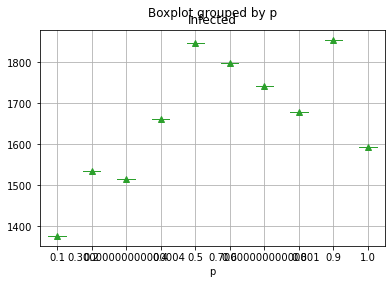

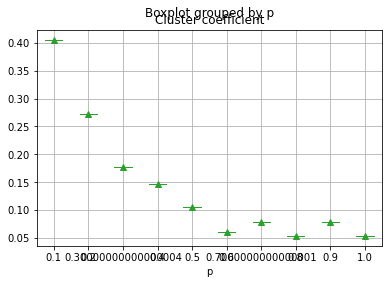

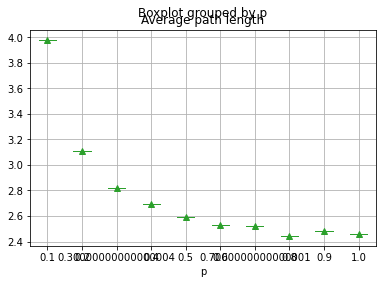

In [21]:
rearranging_df = results_df.groupby(by=["p"]).sum()
print(rearranging_df)
df_cutted = pd.DataFrame(rearranging_df, columns = ["Infected", "Cluster coefficient", "Average path length"])
print(df_cutted)
boxplot = df_cutted.boxplot(column = ["Infected"], by='p', showmeans = True)

rearranging_df = results_df.groupby(by=["p"]).first()
df_cutted = pd.DataFrame(rearranging_df, columns = ["Cluster coefficient", "Average path length"])
print(df_cutted)
boxplot_cc = df_cutted.boxplot(column = ["Cluster coefficient"], by='p', showmeans = True)
boxplot_avg_path_length = df_cutted.boxplot(column = ["Average path length"], by='p', showmeans = True)